##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic regression: Predict outcome variables

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [24]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.13.0


## Load Data


In [32]:
# Set paths
dataPath = '/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_1_gap_measure/3_1_2_processed_data/ml_data/'

# Load data
df = pd.read_csv(dataPath + 'goalDimensions_outcomes.csv')

In [40]:
dataset = df.copy()
dataset.tail()

,ParticipantIdentifier,onOff,category,success,time,import,effort,flourishing_score,harmony_score,qol_score,...,food_fat_score,social_des_score,ambition_score,brief_self_control_score,bsss_overall,future_time_perspective_score,grit_scale_score,need_for_cognition_score,trait_hedonic_capacity_score,domain_gap
4817,ffe41956-4096-4732-8cfb-8192829bd482,offBoarding,Future,88,7.0,5,4.0,6.625,6.0,5.9375,...,1.647059,1.0,4.2,3.153846,2.875,5.5,2.875,3.451613,4.1,26.714286
4818,ffe41956-4096-4732-8cfb-8192829bd482,offBoarding,Finances,74,7.0,6,5.0,6.625,6.0,5.9375,...,1.647059,1.0,4.2,3.153846,2.875,5.5,2.875,3.451613,4.1,26.714286
4819,ffe41956-4096-4732-8cfb-8192829bd482,offBoarding,Time,95,7.0,5,4.0,6.625,6.0,5.9375,...,1.647059,1.0,4.2,3.153846,2.875,5.5,2.875,3.451613,4.1,26.714286
4820,ffe41956-4096-4732-8cfb-8192829bd482,offBoarding,Punctuality,96,7.0,5,6.0,6.625,6.0,5.9375,...,1.647059,1.0,4.2,3.153846,2.875,5.5,2.875,3.451613,4.1,26.714286
4821,ffe41956-4096-4732-8cfb-8192829bd482,offBoarding,Personal,75,7.0,7,6.0,6.625,6.0,5.9375,...,1.647059,1.0,4.2,3.153846,2.875,5.5,2.875,3.451613,4.1,26.714286


In [41]:
dataset.isna().sum()

ParticipantIdentifier              0
onOff                              0
category                           0
success                            0
time                              32
import                             0
effort                            32
flourishing_score                128
harmony_score                    128
qol_score                        128
sat_life_score                   106
sub_happy_score                  106
DASS_overall                     681
perceived_stress_score           671
rosenberg_SES_score              671
con_hex_score                    128
food_fruitveg_score              106
food_fat_score                   106
social_des_score                 128
ambition_score                   681
brief_self_control_score         701
bsss_overall                     671
future_time_perspective_score    681
grit_scale_score                 684
need_for_cognition_score         671
trait_hedonic_capacity_score     671
domain_gap                         0
d

In [42]:
# Specify outcome columns
outcomes = ['flourishing_score',
            'harmony_score',
            'qol_score',
            'sat_life_score',
            'sub_happy_score',
            'DASS_overall',
            'perceived_stress_score',
            'rosenberg_SES_score']

# Reverse score negative outcomes
dataset.perceived_stress_score = 6 - dataset.perceived_stress_score
dataset.DASS_overall = 3 - dataset.DASS_overall

features = ['success', 'import', 'effort', 'time']

# select outcome
outcome = 0

dataset = dataset[features + [outcomes[outcome]]]

### Interactions

In [45]:
dataset['successXimport'] = dataset.success * dataset['import']
dataset['successXtime'] = dataset.success * dataset.time
dataset['successXeffort'] = dataset.success * dataset.effort

In [46]:
dataset = dataset.dropna()

### Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [48]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_1_gap_measure/3_1_3_data_analysis/python_analysis/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


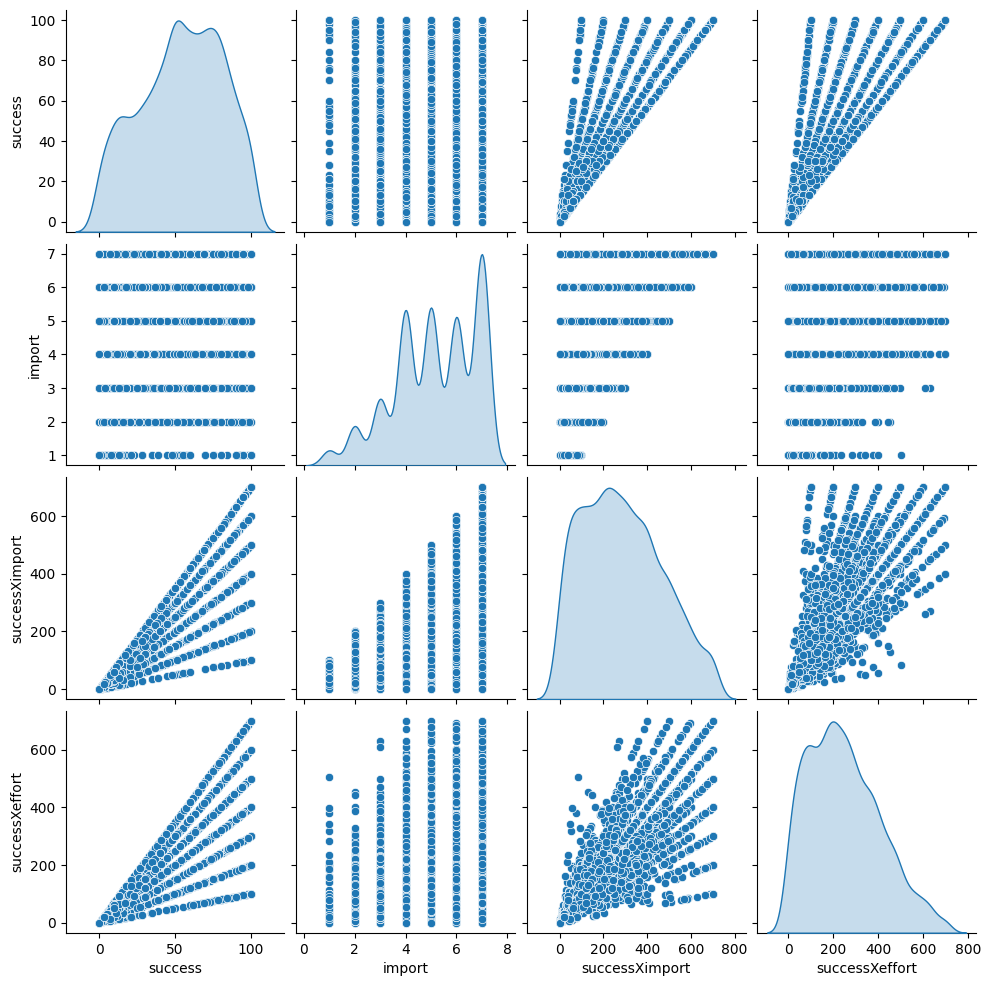

In [17]:
sns.pairplot(train_dataset[['success', 'import', 'successXimport', 'successXeffort']], diag_kind='kde')

Let's also check the overall statistics. Note how each feature covers a very different range:

In [49]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
success,3730.0,54.005630,26.993175,0.0,34.00,55.0,76.00,100.0
import,3730.0,5.150670,1.596567,1.0,4.00,5.0,7.00,7.0
effort,3730.0,4.608043,1.605915,1.0,4.00,5.0,6.00,7.0
time,3730.0,4.444236,1.565149,1.0,3.00,4.0,6.00,7.0
flourishing_score,3730.0,4.951575,1.138863,1.0,4.25,5.0,5.75,7.0
successXimport,3730.0,288.697855,182.443658,0.0,138.00,273.0,420.00,700.0
successXtime,3730.0,246.017694,159.706667,0.0,116.00,230.0,350.00,700.0
successXeffort,3730.0,251.598660,161.341123,0.0,120.00,236.0,360.00,700.0


### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [50]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop(outcomes[outcome])
test_labels = test_features.pop(outcomes[outcome])

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [51]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
success,54.005630,26.993175
import,5.150670,1.596567
effort,4.608043,1.605915
time,4.444236,1.565149
flourishing_score,4.951575,1.138863
successXimport,288.697855,182.443658
successXtime,246.017694,159.706667
successXeffort,251.598660,161.341123


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model *might* converge without feature normalization, normalization makes training much more stable.

Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity. For more details on how to use the preprocessing layers, refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [52]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [53]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [54]:
print(normalizer.mean.numpy())

[[ 54.006   5.151   4.608   4.444 288.698 246.018 251.599]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [55]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 73.   6.   4.   6. 438. 438. 292.]]

Normalized: [[ 0.7   0.53 -0.38  0.99  0.82  1.2   0.25]]


## Linear regression

Before building a deep neural network model, start with linear regression using one and several variables.

### Linear regression with one variable

Begin with a single-variable linear regression to predict `'flourishing'` from `'successXimport'`.

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which [represents a sequence of steps](https://www.tensorflow.org/guide/keras/sequential_model).

There are two steps in your single-variable linear regression model:

- Normalize the `'successXimport'` input features using the `tf.keras.layers.Normalization` preprocessing layer.
- Apply a linear transformation ($y = mx+b$) to produce 1 output using a linear layer (`tf.keras.layers.Dense`).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the `'successXimport'` features. Then, instantiate the `tf.keras.layers.Normalization` and fit its state to the `successXimport` data:

In [58]:
successXimport = np.array(train_features['successXimport'])

successXimport_normalizer = layers.Normalization(input_shape=[1,], axis=None)
successXimport_normalizer.adapt(successXimport)

Build the Keras Sequential model:

In [59]:
successXimport_model = tf.keras.Sequential([
    successXimport_normalizer,
    layers.Dense(units=1)
])

successXimport_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 normalization_1 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


This model will predict `'Outcome'` from `'successXimport'`.

Run the untrained model on the first 10 'successXimport' values. The output won't be good, but notice that it has the expected shape of `(10, 1)`:

In [60]:
successXimport_model.predict(successXimport[:10])

1/1 [==============================] - 0s 133ms/step


array([[-0.496],
       [-1.367],
       [ 0.308],
       [ 0.561],
       [-0.599],
       [ 0.959],
       [-0.204],
       [-0.735],
       [ 0.494],
       [ 0.129]], dtype=float32)

Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized (`mean_absolute_error`) and how (using the `tf.keras.optimizers.Adam`).

In [61]:
successXimport_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Use Keras `Model.fit` to execute the training for 100 epochs:

In [63]:
%%time
history = successXimport_model.fit(
    train_features['successXimport'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 6.54 s, sys: 1.54 s, total: 8.08 s
Wall time: 6.99 s


Visualize the model's training progress using the stats stored in the `history` object:

In [64]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.871464,0.875588,95
96,0.871471,0.877246,96
97,0.867884,0.872707,97
98,0.868024,0.878915,98
99,0.868729,0.876118,99


In [67]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 4])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

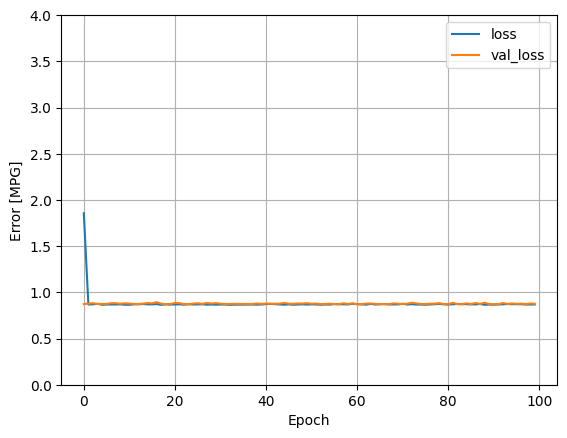

In [68]:
plot_loss(history)

Collect the results on the test set for later:

In [69]:
test_results = {}

test_results['successXimport_model'] = successXimport_model.evaluate(
    test_features['successXimport'],
    test_labels, verbose=0)

Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

In [70]:
x = tf.linspace(0.0, 250, 251)
y = successXimport_model.predict(x)

8/8 [==============================] - 0s 3ms/step


In [74]:
def plot_outcome(x, y):
  plt.scatter(train_features['successXimport'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('successXimport')
  plt.ylabel(outcomes[outcome])
  plt.legend()

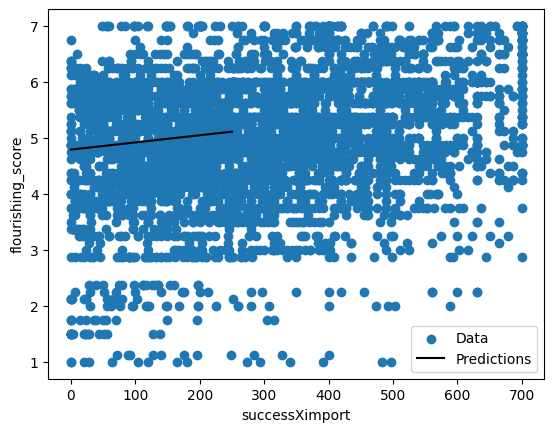

In [75]:
plot_outcome(x, y)

### Linear regression with multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) you defined earlier and adapted to the whole dataset:

In [76]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call `Model.predict` on a batch of inputs, it produces `units=1` outputs for each example:

In [77]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 32ms/step


array([[-0.299],
       [-0.666],
       [-0.315],
       [-0.03 ],
       [-0.82 ],
       [-1.017],
       [ 0.581],
       [ 0.525],
       [ 1.571],
       [ 0.222]], dtype=float32)

When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y=mx+b$) have a shape of `(9, 1)`:

In [78]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(7, 1) dtype=float32, numpy=
array([[ 0.545],
       [ 0.215],
       [ 0.66 ],
       [-0.742],
       [-0.715],
       [ 0.704],
       [-0.277]], dtype=float32)>

Configure the model with Keras `Model.compile` and train with `Model.fit` for 100 epochs:

In [79]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [80]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 6.44 s, sys: 1.51 s, total: 7.95 s
Wall time: 6.83 s


Using all the inputs in this regression model achieves a much lower training and validation error than the `successXimport`, which had one input:

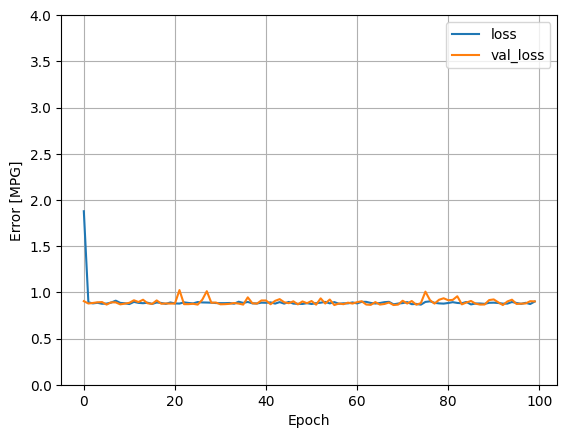

In [81]:
plot_loss(history)

Collect the results on the test set for later:

In [82]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `horsepower_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure, so the `compile` method is included in the `build_and_compile_model` function below.

In [83]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regression using a DNN and a single input

Create a DNN model with only `'successXimport'` as input and `successXimport_normalizer` (defined earlier) as the normalization layer:

In [84]:
dnn_successXimport_model = build_and_compile_model(successXimport_normalizer)

This model has quite a few more trainable parameters than the linear models:

In [85]:
dnn_successXimport_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4356 (17.02 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


Train the model with Keras `Model.fit`:

In [86]:
%%time
history = dnn_successXimport_model.fit(
    train_features['successXimport'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 7.96 s, sys: 2.28 s, total: 10.2 s
Wall time: 8.51 s


This model does slightly better than the linear single-input `successXimport`:

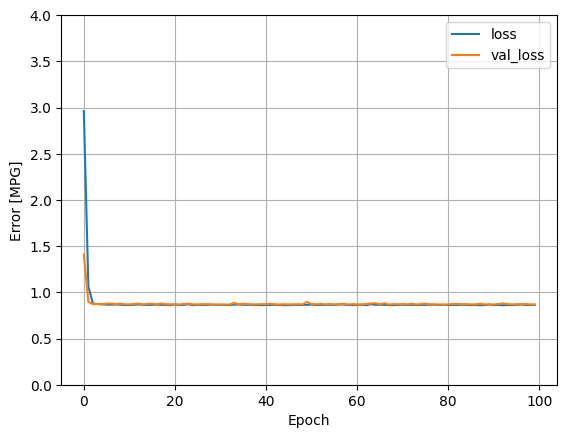

In [87]:
plot_loss(history)

If you plot the predictions as a function of `'successXimport'`, you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [88]:
x = tf.linspace(0.0, 250, 251)
y = dnn_successXimport_model.predict(x)

8/8 [==============================] - 0s 1ms/step


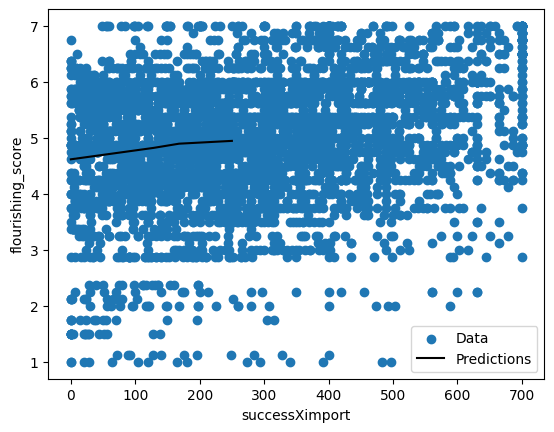

In [89]:
plot_outcome(x, y)

Collect the results on the test set for later:

In [90]:
test_results['dnn_successXimport_model'] = dnn_successXimport_model.evaluate(
    test_features['successXimport'], test_labels,
    verbose=0)

### Regression using a DNN and multiple inputs

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [91]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 7)                 15        
 on)                                                             
                                                                 
 dense_5 (Dense)             (None, 64)                512       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4752 (18.57 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 15 (64.00 Byte)
_________________________________________________________________


In [96]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 7.84 s, sys: 2.7 s, total: 10.5 s
Wall time: 8.12 s


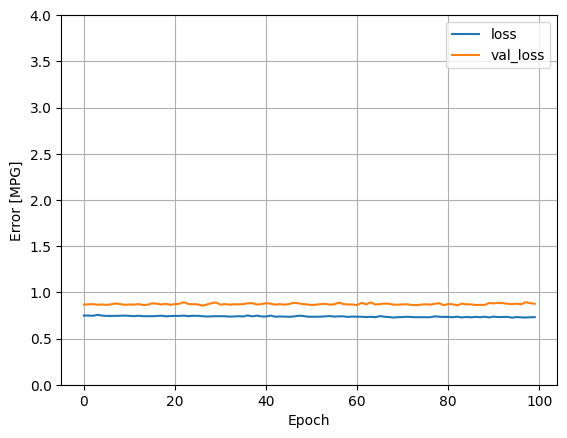

In [97]:
plot_loss(history)

Collect the results on the test set:

In [98]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

Since all models have been trained, you can review their test set performance:

In [99]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
successXimport_model,0.849036
linear_model,0.889321
dnn_successXimport_model,0.840227
dnn_model,0.852125


These results match the validation error observed during training.

### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:


1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 2ms/step


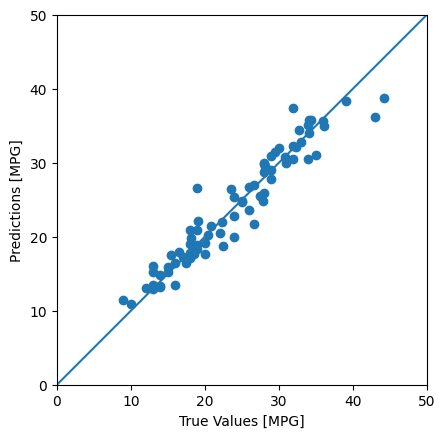

In [53]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It appears that the model predicts reasonably well.

Now, check the error distribution:

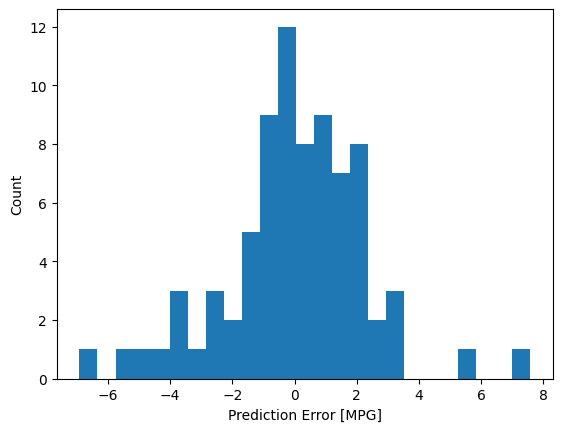

In [54]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

In [55]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


If you reload the model, it gives identical output:

In [56]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [57]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.639396
linear_model,2.461067
dnn_horsepower_model,2.930267
dnn_model,1.634122
reloaded,1.634122


## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) and mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.